In [65]:
# Importing initial packages
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette("deep")
import matplotlib.pyplot as plt

# Setting the device to GPU for parallelization
device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

mps


In [66]:
# Setting Hyperparameters
batch_size = 64
epochs = 4

In [67]:
# In my project folder I added a data folder with both files (found in repo README) but did not push (gitignore) due to size
movies = pd.read_csv('data/movies.csv')

ratings = pd.read_csv('data/ratings.csv')

In [68]:
# Creating encoders and decoders for our movie ids
movie_ids = list(movies.movieId)
moviesid_to_title = dict(zip(movies.movieId,movies.title))    # Decoder
movietitle_to_id = {j:i for i,j in moviesid_to_title.items()} # Encoder

movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Data Preprocessing

In [69]:
# Assume NAs are not watched by user, so rating of 0
user_rating_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
user_rating_matrix_np = user_rating_matrix.values
train_data, test_data = train_test_split(user_rating_matrix_np, test_size=0.2, random_state=42)
train_data = torch.FloatTensor(train_data)
test_data = torch.FloatTensor(test_data)

In [70]:
class RatingsDataset(Dataset):
    def __init__(self, data):
        self.data = data.nonzero(as_tuple=True) # Get the indices of non-zero elements
        self.ratings = data[self.data]          # Using non-zero indiced to extract those ratings

    def __len__ (self):
        return len(self.data[0])
    
    def __getitem__ (self, idx):
        user = self.data[0][idx]
        item = self.data[1][idx]
        rating = self.ratings[idx]
        
        return user, item, rating
    
train_dataset = RatingsDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

test_dataset = RatingsDataset(test_data)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle = False)

In [71]:
criterion = nn.MSELoss()
num_users, num_items = user_rating_matrix_np.shape

# Models

### Model 1

Original Model Architecture
- Embed_Dim = 64
- 4 Linear Layers (128>128>64>16>1)
- 2 Dropouts (0.5, 0.4)
- 3 Batch Norms

In [72]:
class Model1(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Model1, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 64)                         # Second fc layer
        self.fc3 = nn.Linear(64, 16)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(16, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model1(num_users= num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model1(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Model 2

- Embed_Dim = 32
- 4 Linear Layers (64>128>64>16>1)
- 2 Dropouts (0.5, 0.4)
- 3 Batch Norms

Less model complexity compared to Model 1 to combat overfitting

In [73]:
class Model2(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 32):
        super(Model2, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 64)                         # Second fc layer
        self.fc3 = nn.Linear(64, 16)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(16, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model2(num_users = num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model2(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Model 3
- Embed_Dim = 32
- 3 Linear Layers (64>128>32>1)
- 1 Dropout (0.5)
- 2 Batch Norms

Less model complexity compared to Model 2 to increase generalization

In [74]:
class Model3(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 32):
        super(Model3, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 32)                         # Second fc layer
        self.fc3 = nn.Linear(32, 1)                          # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(32)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model3(num_users = num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model3(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Model 4
- Embed_Dim = 64
- 4 Linear Layers (64>128>32>1)
- 1 Dropout (0.5)
- 2 Batch Norms

Same number of linear layers as Model 1, but smaller dropouts and less neurons.

In [75]:
class Model4(nn.Module):
    def __init__(self, num_users, num_items, n_embd = 64):
        super(Model4, self).__init__()
        self.user_embedding = nn.Embedding(num_users, n_embd) # Creating an embedding for our users with the correct dimensions
        self.item_embedding = nn.Embedding(num_items, n_embd) # Embedding items
        
        self.fc1 = nn.Linear(n_embd * 2, 128)                 # First fully connected (fc) layer
        self.fc2 = nn.Linear(128, 64)                         # Second fc layer
        self.fc3 = nn.Linear(64, 16)                          # Finaly fc layer, with an output of one value
        self.fc4 = nn.Linear(16, 1)                           # Finaly fc layer, with an output of one value
       
        self.sigmoid = nn.Sigmoid()                           # Sigmoid activation function to compress the output to a value between (0,1)
        
        self.dropout1 = nn.Dropout(0.5)                       # Dropout layer to prevent overfitting
        self.dropout2 = nn.Dropout(0.4)                       # Dropout layer to prevent overfitting
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(16)


    def forward(self, user, item):
        user_embed = self.user_embedding(user)          # Embedding our users
        item_embed = self.item_embedding(item)          # Embedding the movies
        
        x = torch.cat([user_embed, item_embed], dim=-1) # Concatenating the users and items 
        x = torch.relu(self.fc1(x))                     # Applying first fc layer, with a ReLU activation function
        x = self.bn1(x)
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.fc4(x)                                 # Final layer to get predicted rating
        x = self.sigmoid(x)                             # Applying the sigmoid function
        x = x*5                                         # Scale the output from [0,1] to [0,5]   
        return x

def initialise_model4(num_users= num_users, num_items=num_items, lr=0.03, wd=2.5e-5):
    global model
    model = Model4(num_users, num_items)
    model = model.to(device)
    global optimizer
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

## Training Loop Function

In [76]:
def training_loop(epochs=epochs):
    model.train()
    for epoch in range(1, epochs+1):
        total_loss = 0
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            optimizer.zero_grad()
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Print loss after every epoch
        epoch_loss = total_loss/len(train_loader)          # Get the average loss for this epoch
        print(f"    Epoch {epoch}, Loss: {epoch_loss}")    # Print the average loss for this epoch
    
    return epoch_loss                                      # Return the final loss

# training_loop()

## Val Loop Function

In [77]:
def validation_loop():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for user, item, rating in test_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            output = model(user, item).squeeze()
            loss = criterion(output, rating)
            total_loss += loss.item()
        
    test_loss = total_loss / len(test_loader)   

    print(f"    Test Loss: {test_loss}")
    return test_loss

# Model Testing

### Defining a fn to loop through Learning Rates, returning a dict of losses.

In [78]:
learning_rates = [0.0005]#,0.001, 0.003, 0.005, 0.01, 0.013, 0.015]
wd_list = [1e-5, 1.5e-5, 2e-5, 2.5e-5]

def parameter_fn(model = initialise_model1, name = "Model 1", lr_list= learning_rates, epochs = epochs):
    lr_dict = {'Name': name, 'learning_rate': [], 'weight_decay':[], 'training_loss': [], 'test_loss': [], 'test_diff':[]}
    for lr in lr_list:
        for wd in wd_list:
            print(f"Learning Rate: {lr}, Weight Decay: {wd}")
            model(lr=lr)
            training_loss = training_loop(epochs)
            test_loss = validation_loop()
            
            lr_dict['weight_decay'].append(wd)
            lr_dict['learning_rate'].append(lr)
            lr_dict['training_loss'].append(training_loss)
            lr_dict['test_loss'].append(test_loss)
            lr_dict['test_diff'].append((test_loss/training_loss)-1)

    return lr_dict

# lr_df=pd.DataFrame(learning_rate_fn())
# lr_df.sort_values(by='test_diff', ascending=True)

In [79]:
models = {initialise_model1:"Model 1", initialise_model2:"Model 2", initialise_model3:"Model 3"}
loss_df = pd.DataFrame()
for model, name in models.items():
    print(f"Now processing: {name}")
    loss_dict = parameter_fn(model = model, name = name)
    loss_df = pd.concat([loss_df, pd.DataFrame(loss_dict)], ignore_index=True)
    
loss_df

Now processing: Model 1
Learning Rate: 0.0005
    Epoch 1, Loss: 1.3202411105686969
    Epoch 2, Loss: 1.0294008000226287
    Epoch 3, Loss: 0.9773169207823026
    Epoch 4, Loss: 0.9416111606609571
    Test Loss: 0.9536372497849872
Learning Rate: 0.0005
    Epoch 1, Loss: 1.4265778705060899
    Epoch 2, Loss: 1.0241789845424099
    Epoch 3, Loss: 0.9734814175359019
    Epoch 4, Loss: 0.9360131395759282
    Test Loss: 0.9621827895247633
Learning Rate: 0.0005
    Epoch 1, Loss: 1.2891746784423614
    Epoch 2, Loss: 1.004556462950223
    Epoch 3, Loss: 0.9576908595130577
    Epoch 4, Loss: 0.9209135133851242
    Test Loss: 1.0181428350284523
Learning Rate: 0.0005
    Epoch 1, Loss: 1.4451603607593717
    Epoch 2, Loss: 1.0184303770636345
    Epoch 3, Loss: 0.9682744773222016
    Epoch 4, Loss: 0.9328092179827757
    Test Loss: 0.9866712789543782
Now processing: Model 2
Learning Rate: 0.0005
    Epoch 1, Loss: 1.4337491545748045
    Epoch 2, Loss: 1.0663745112039826
    Epoch 3, Loss: 1.02

# Checking Model

In [ ]:
def ratings_review(user_id, movie_ids):
    model.eval()                                 # Set model to evaluation mode
    user = torch.tensor([user_id] * len(movie_ids)).to(device)  # Ensure tensor is on the same device as the model
    movies = torch.tensor(movie_ids).to(device)  # Ensure tensor is on the same device as the model
    with torch.no_grad():
        predicted_ratings = model(user, movies).squeeze().tolist()

    return predicted_ratings

ratings_list = []
for id in ratings.userId.unique():
        recommended_movies = ratings_review(id, movie_ids)
        ratings_list.append(recommended_movies[0])

<Axes: >

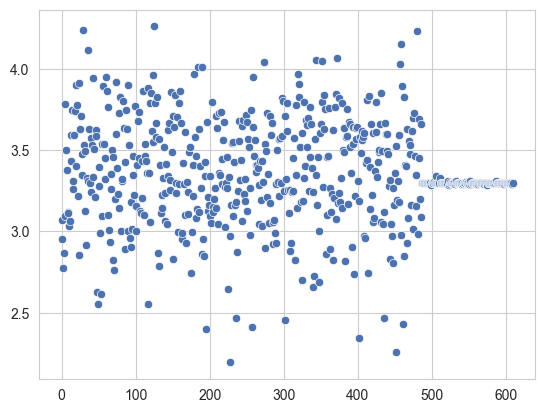

In [ ]:
sns.scatterplot(ratings_list)
plt.plot()

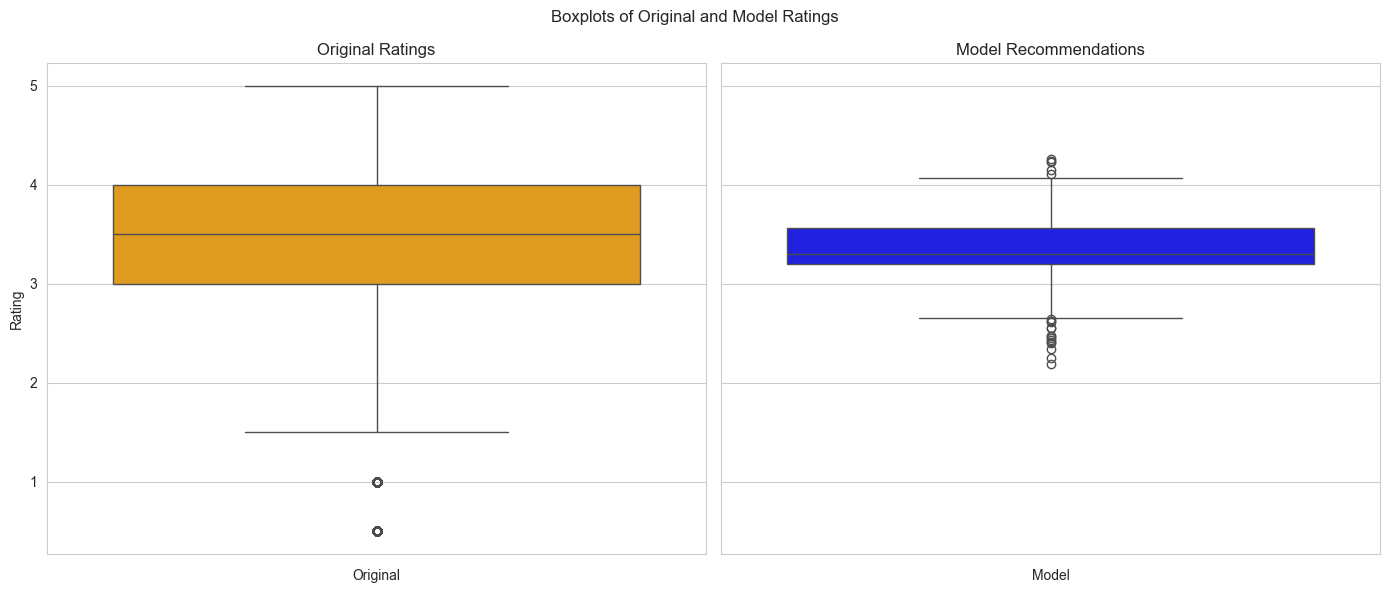

In [ ]:
ratings_series = pd.Series(ratings_list)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Original Data
sns.boxplot(y=ratings['rating'], ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Original')
axes[0].set_ylabel('Rating')

# Model Data
sns.boxplot(y=ratings_series, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Model')

# Adjust layout
plt.suptitle('Boxplots of Original and Model Ratings')
plt.tight_layout()
plt.show()

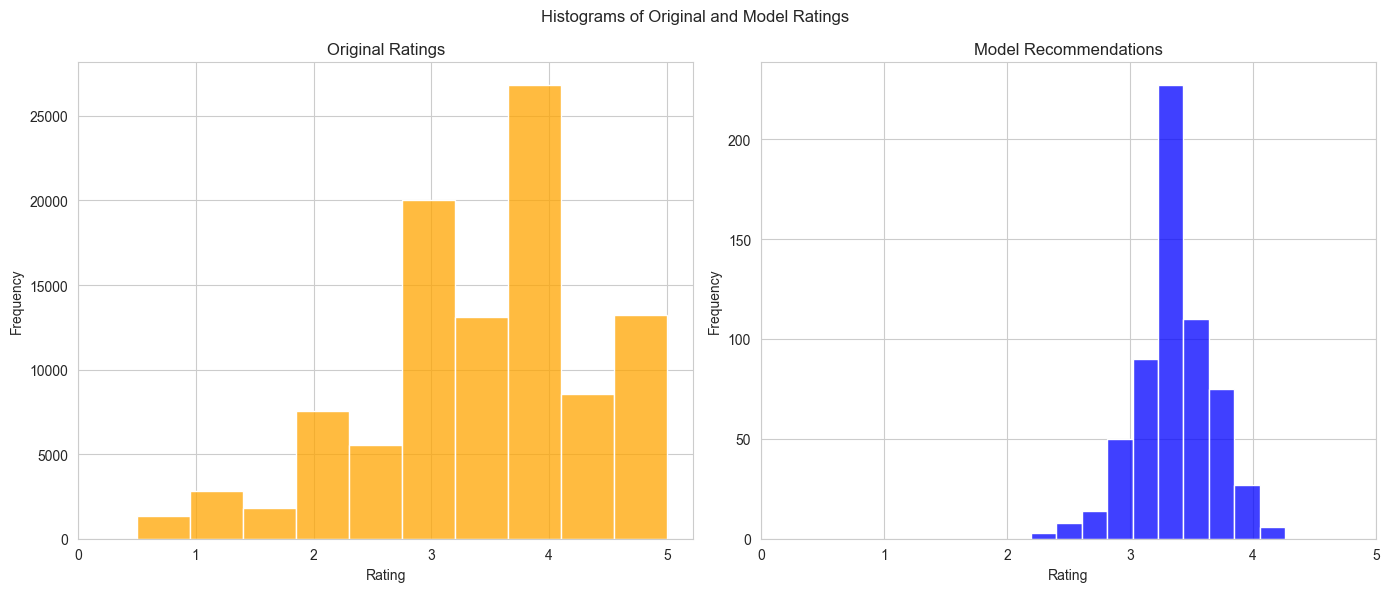

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
xticks = [0, 1, 2, 3, 4, 5]

bins = 10
# Original Data
sns.histplot(x=ratings['rating'], bins = bins, ax=axes[0], color='orange')
axes[0].set_title('Original Ratings')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')
axes[0].set_xticks(xticks)

# Model Data
sns.histplot(x=ratings_series, bins = bins, ax=axes[1], color='blue')
axes[1].set_title('Model Recommendations')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks(xticks)


# Adjust layout
plt.suptitle('Histograms of Original and Model Ratings')
plt.tight_layout()
plt.show()

In [ ]:
ratings_series = pd.Series(ratings_list)
ratings_series.describe()

count    610.000000
mean       3.352686
std        0.311605
min        2.193993
25%        3.201938
50%        3.297724
75%        3.566542
max        4.260009
dtype: float64

In [ ]:
ratings.rating.describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64